In [3]:
# default_exp geometry.abstract_geometry

# Create abstract geometry

> API details.

In [4]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [5]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
from scipy import stats
import numpy as np
import pickle

In [6]:
#export
def generate_random_circle_in_box(box_size, circle_radius, gap):
    """distance from box edge is 2xcircel_radius"""
    center_x = np.random.random() * (box_size[0] - 2*(circle_radius + gap)) + (circle_radius + gap)
    center_y = np.random.random() * (box_size[1] - 2*(circle_radius + gap)) + (circle_radius + gap)

    circle = Point(center_x, center_y).buffer(circle_radius)

    return circle

POINT (173.7412342186656 97.20004175901614)


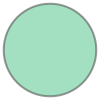

In [7]:
circle = generate_random_circle_in_box((200,200), 10, 5)
print(circle.centroid)
circle

In [8]:
#export
def has_enough_distance_from_circles(circle, other_circles, gap):
    other_circles = MultiPolygon(other_circles)
    """too close is when they are circle_radius closer"""
    return circle.distance(other_circles) > gap

In [9]:
circles = []
for i in range(10):
    circle = generate_random_circle_in_box((100,100), circle_radius=10, gap=10)
    circles.append(circle)

circle = generate_random_circle_in_box((100,100), circle_radius=10, gap=10)

print("distance to other circles:", [circle.distance(other_circle) for other_circle in circles])
print("has enough distance:", has_enough_distance_from_circles(circle, circles, gap))

distance to other circles: [0.0, 31.858222095072186, 29.74948698072104, 34.29948400248392, 29.69764089409307, 33.16368852220193, 37.1071077661598, 42.308808246290134, 27.829375003351593, 0.0]
has enough distance: False


In [10]:
#export
def get_random_circle_radius(circle_radius_range):
    return np.random.random()*(circle_radius_range[1] - circle_radius_range[0]) + circle_radius_range[0]

In [11]:
#export
class AbstractGeometry:
    def __init__(self, circle_density, circle_radius_range, box_size, gap, seed):
        self.final_box_size = box_size
        self.box_size = [2*d for d in box_size]
        self.circle_radius_range = circle_radius_range
        self.gap = gap
        self.seed = seed

        self.n_circles = self._compute_n_circles(circle_density)
    
    def get_geom_info(self):
        circles = self._generate_random_circles()
        circles = self._crop_to_final_box_size(circles)
        box_coordinates = self._get_box_coordinates(self.final_box_size)

        return circles, box_coordinates

    def _compute_n_circles(self, circle_density):
        box_area = self.box_size[0] * self.box_size[1]
        avg_circle_radius = np.sqrt(self.circle_radius_range[0] * self.circle_radius_range[1])
        avg_circle_area = np.pi*avg_circle_radius**2
        effective_box_area = box_area * circle_density
        n_circles = effective_box_area / avg_circle_area
        return n_circles

    def _crop_to_final_box_size(self, circles):
        a0, b0 = self.box_size
        a, b = self.final_box_size

        final_box = Polygon([
            [(a0-a)/2, (b0-b)/2], 
            [(a0+a)/2, (b0-b)/2],
            [(a0+a)/2, (b0+b)/2],
            [(a0-a)/2, (b0+b)/2],
            [(a0-a)/2, (b0-b)/2],
        ])

        return circles.intersection(final_box)
    
    def _get_box_coordinates(self, box_size):
        return [[0, 0], 
                [box_size[0], 0], 
                [box_size[0], box_size[1]], 
                [0, box_size[1]]]
    
    def _generate_random_circles(self):
        np.random.seed(self.seed)

        counter = 0
        attempts = 0

        while counter < self.n_circles:
            circle_radius = get_random_circle_radius(self.circle_radius_range)

            if counter == 0 and attempts == 0:
                circle = generate_random_circle_in_box(
                    self.box_size, 
                    circle_radius=circle_radius, 
                    gap=self.gap)

                circles = MultiPolygon([circle])

            attempts += 1
            if attempts > 100 * self.n_circles:
                print(f'''[WARNING] {attempts} attempts, reduce circle radius, increase box size, or decrease number of circles 
                returning {len(circles)} circles''')
                return circles

            circle = generate_random_circle_in_box(
                self.box_size, 
                circle_radius=circle_radius,
                gap=self.gap)

            if has_enough_distance_from_circles(circle, circles, self.gap):

                circles_tmp = MultiPolygon([g for g in circles.geoms] + [circle])
                if circles_tmp.is_valid:
                    circles = circles_tmp
                    counter += 1
        
        return circles
        
    def save_at(self, path):
        with open(path, 'wb') as handle:
            pickle.dump(self, handle)

[WARNING] 4584 attempts, reduce circle radius, increase box size, or decrease number of circles 
                returning 21 circles


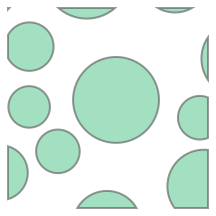

In [12]:
box_size = (200, 200)
circle_radius_range = (20, 50)
gap = 10
circle_density = 0.90

abstract_geometry = AbstractGeometry(circle_density, circle_radius_range, box_size, gap, seed=None)
circles, box_coordinates = abstract_geometry.get_geom_info()

circles